In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/annotated dataset'
print(os.listdir(path))

['train', 'valid', 'test', 'data.yaml']


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15943, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15943 (delta 28), reused 31 (delta 12), pack-reused 15880
Receiving objects: 100% (15943/15943), 14.67 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (10923/10923), done.


In [ ]:
%cd yolov5/

/content/yolov5


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import torch
from pathlib import Path
from models.yolo import attempt_load

In [ ]:
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
import numpy as np

In [ ]:
import os
import shutil

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-214-g8c30c58 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = F.resize(img, (640, 640))
    img = F.pad(img, (0, 0, 640 - img.width, 640 - img.height), 0)
    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0)  # Add batch dimension
    return img

In [ ]:
def extract_features(model, image_path):
    img = preprocess_image(image_path)

    # Run inference
    with torch.no_grad():
        detections = model(img)[0]

    return detections

In [ ]:
import glob

In [ ]:
dataset_path = "/content/drive/MyDrive/annotated dataset/train/images"
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))

for image_file in image_files:
    detections = extract_features(model, image_file)

In [ ]:
detections.shape

torch.Size([25200, 85])

In [ ]:
detections

tensor([[5.35652e+00, 6.14628e+00, 1.08788e+01,  ..., 4.21913e-03, 6.16112e-04, 3.13705e-03],
        [9.33595e+00, 5.68742e+00, 1.99577e+01,  ..., 4.49291e-03, 8.96541e-04, 4.76368e-03],
        [1.94050e+01, 5.39683e+00, 3.16496e+01,  ..., 4.24910e-03, 7.44763e-04, 3.70467e-03],
        ...,
        [5.60763e+02, 6.01102e+02, 1.50471e+02,  ..., 6.97205e-03, 1.20349e-03, 1.92620e-03],
        [5.87517e+02, 6.07071e+02, 1.09591e+02,  ..., 2.58549e-02, 2.55863e-03, 4.12484e-03],
        [6.17746e+02, 6.15457e+02, 1.17109e+02,  ..., 2.62940e-02, 2.37748e-03, 2.11431e-03]], device='cuda:0')

In [ ]:
# Training configuration
dataset_path = "/content/drive/MyDrive/annotated dataset/train/images"
annotations_path = "/content/drive/MyDrive/annotated dataset/train/labels"
batch_size = 4
epochs = 30
learning_rate = 0.001

In [ ]:
# Create necessary directories
os.makedirs(annotations_path, exist_ok=True)

In [ ]:
# Prepare training data
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
train_txt_path = os.path.join(annotations_path, "train.txt")
with open(train_txt_path, "w") as f:
    for image_file in image_files:
        f.write(image_file + "\n")

In [ ]:
# Start training
command = f"python train.py --img 640 --batch {batch_size} --epochs {epochs} --data coco.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_result"
os.system(command)

0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
!pip install matplotlib scikit-learn


In [ ]:
!cp -r /content/yolov5/runs/train/yolov5s_result3 /content/drive/MyDrive/yolov5/result

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_result3/weights/best.pt --source "/content/drive/MyDrive/annotated dataset/test/images/15143_jpg.rf.93786f787975776ddea4354030ae8dd4.jpg" --conf-thres 0.015 --imgsz 640


detect: weights=['/content/yolov5/runs/train/yolov5s_result3/weights/best.pt'], source=/content/drive/MyDrive/annotated dataset/test/images/15143_jpg.rf.93786f787975776ddea4354030ae8dd4.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.015, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-214-g8c30c58 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/annotated dataset/test/images/15143_jpg.rf.93786f787975776ddea4354030ae8dd4.jpg: 640x640 1 Non_Crack, 11.6ms
Speed: 0.7ms pre-process, 11.6ms inference, 75.8ms NMS per image at shape 

In [ ]:
!cp -r /content/yolov5/runs/detect /content/drive/MyDrive/yolov5/test_results

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_result3/weights/best.pt --source "/content/drive/MyDrive/annotated dataset/test/images/00006_jpg.rf.67273dfbd2e6a4195302190094ac27f0.jpg" --conf-thres 0.015 --imgsz 640


detect: weights=['/content/yolov5/runs/train/yolov5s_result3/weights/best.pt'], source=/content/drive/MyDrive/annotated dataset/test/images/00006_jpg.rf.67273dfbd2e6a4195302190094ac27f0.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.015, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-214-g8c30c58 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/annotated dataset/test/images/00006_jpg.rf.67273dfbd2e6a4195302190094ac27f0.jpg: 640x640 3 Cracks, 1 Non_Crack, 11.6ms
Speed: 0.7ms pre-process, 11.6ms inference, 76.7ms NMS per image

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_result3/weights/best.pt --source "/content/drive/MyDrive/annotated dataset/test/images/00013_jpg.rf.d8f75f90b72df94ff17bd5d3ab528d4a.jpg" --conf-thres 0.015 --imgsz 640


detect: weights=['/content/yolov5/runs/train/yolov5s_result3/weights/best.pt'], source=/content/drive/MyDrive/annotated dataset/test/images/00013_jpg.rf.d8f75f90b72df94ff17bd5d3ab528d4a.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.015, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-214-g8c30c58 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/annotated dataset/test/images/00013_jpg.rf.d8f75f90b72df94ff17bd5d3ab528d4a.jpg: 640x640 2 Cracks, 11.6ms
Speed: 0.8ms pre-process, 11.6ms inference, 75.2ms NMS per image at shape (1,

In [ ]:
root_path = '/content/drive/MyDrive/PR_RESULT'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'best.pt')

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'best.pt'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
image_path = "/content/yolov5/runs/train/yolov5s_result3/confusion_matrix.png"


In [ ]:
from PIL import Image, ImageDraw
from IPython.display import display

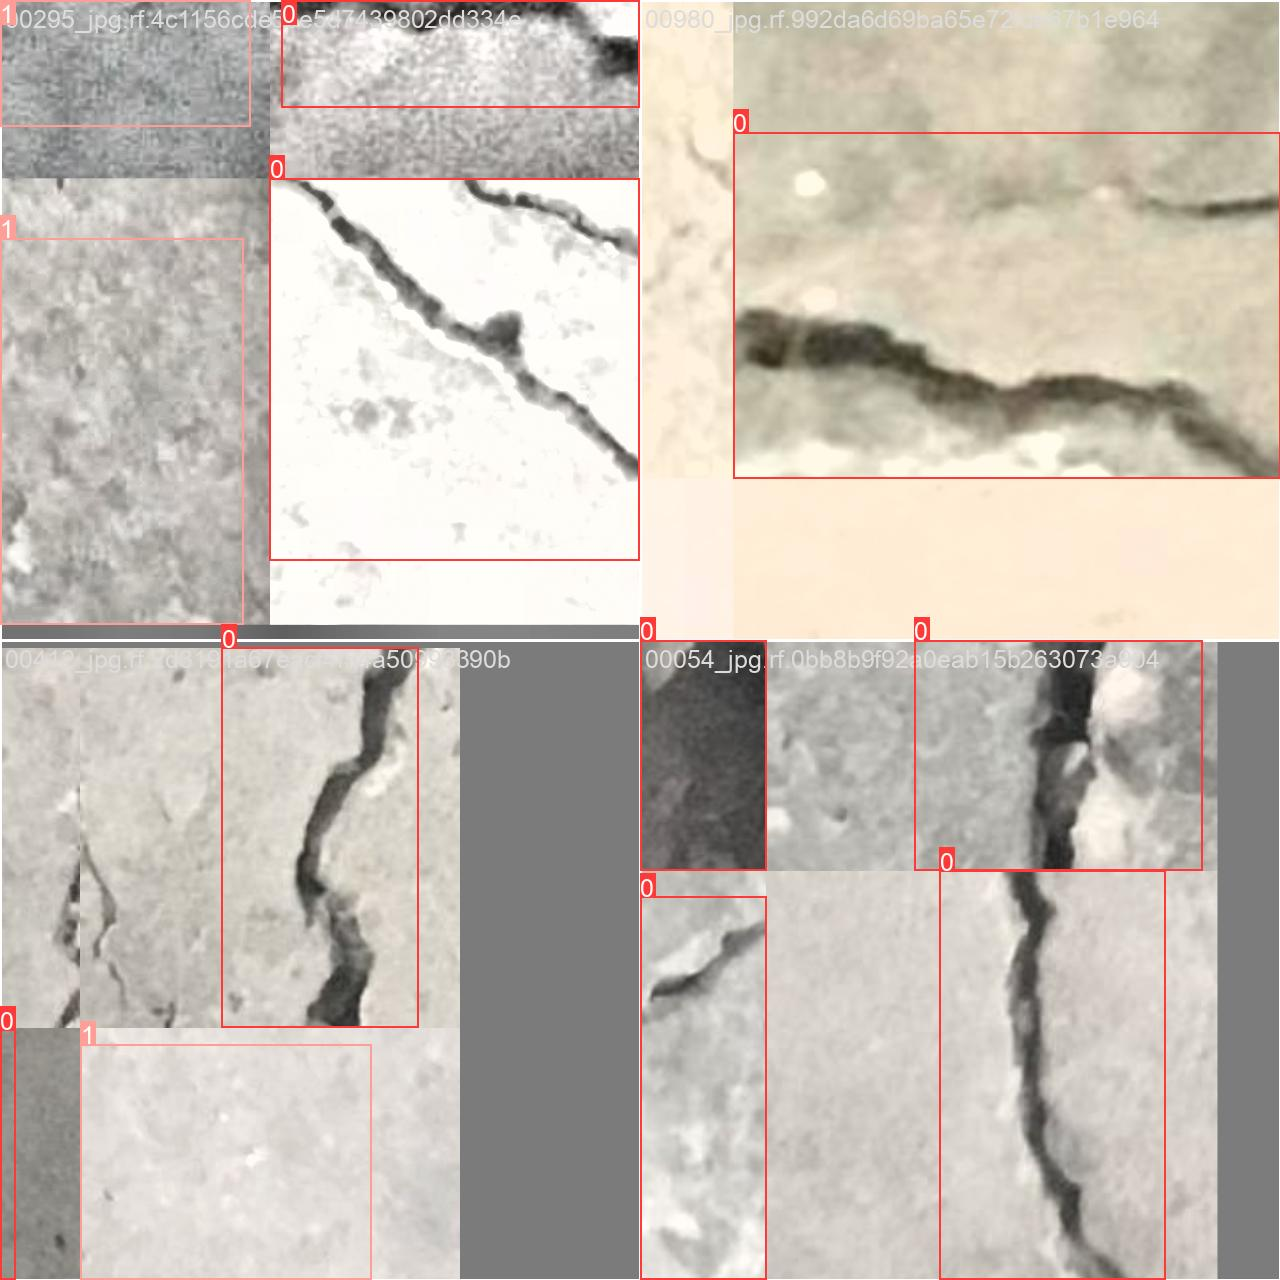

In [ ]:
from PIL import Image
from IPython.display import display

# Load the PNG image using Image.open() from PIL
# Replace 'your_image.png' with the path to your PNG image file
image_path = '/content/yolov5/runs/train/yolov5s_result3/train_batch1.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

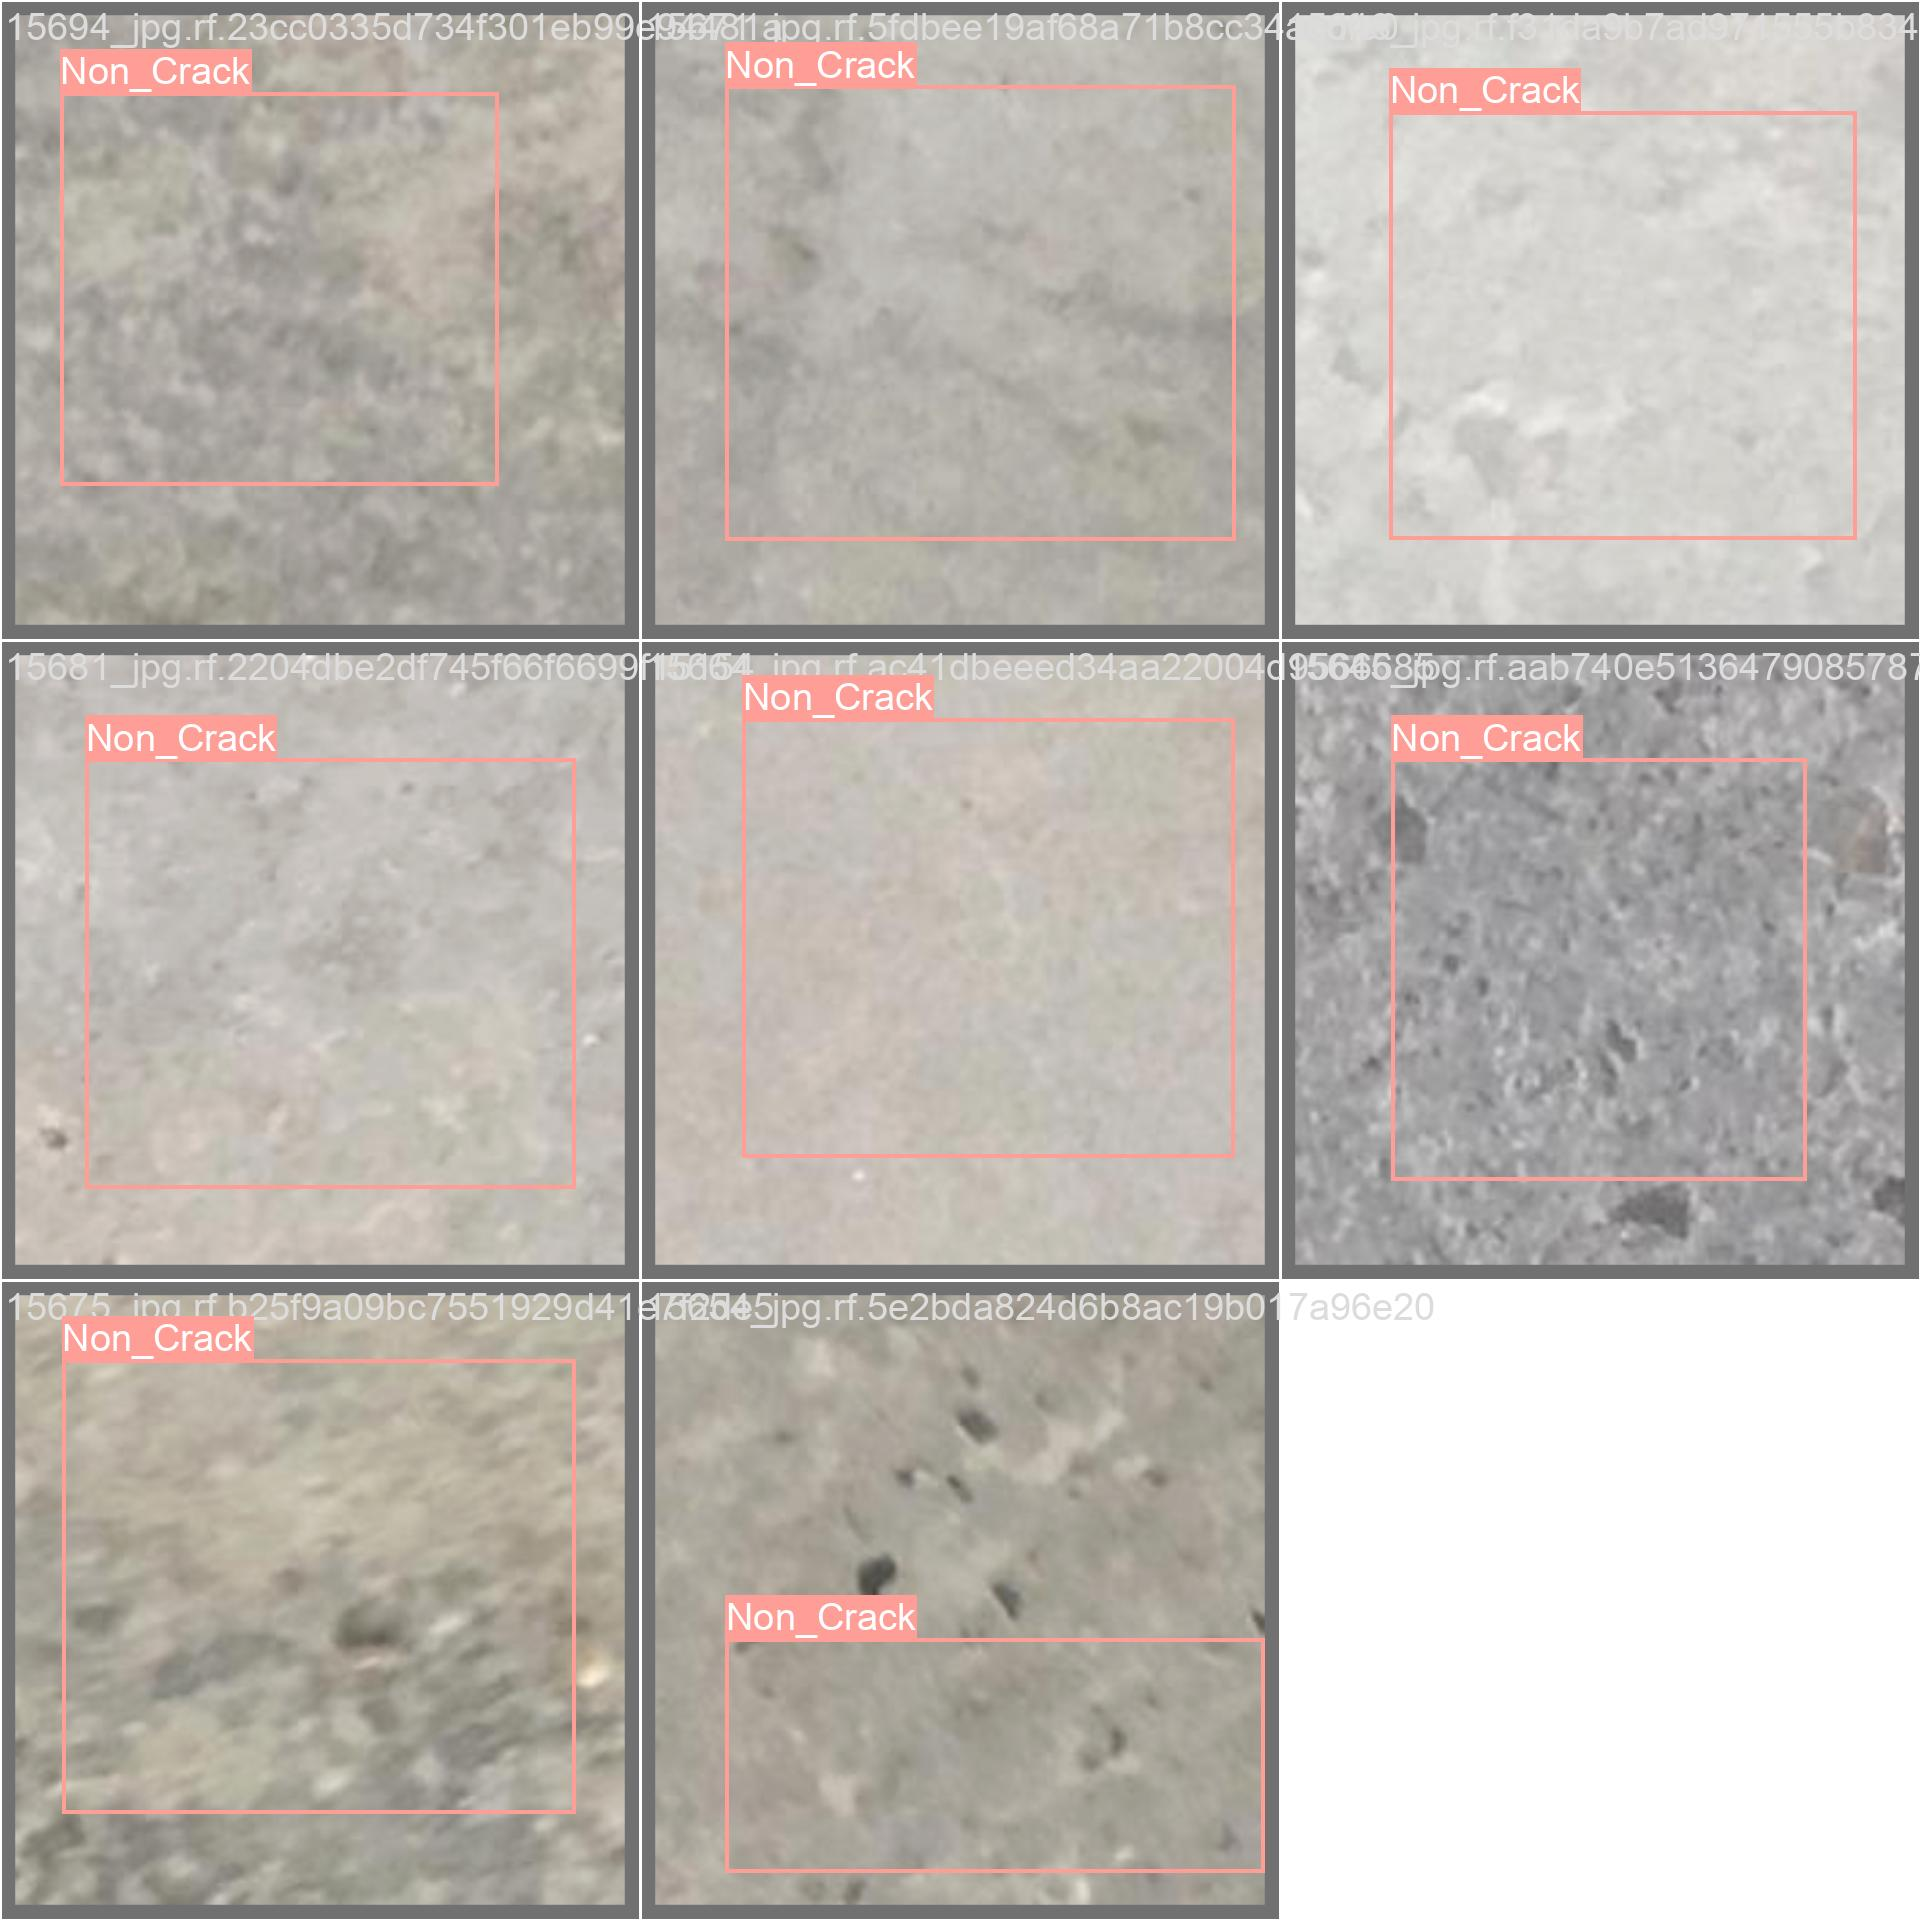

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result3/val_batch1_labels.jpg'
img = Image.open(image_path)
# Display the image using IPython.display
display(img)

draw = ImageDraw.Draw(img)
label='Validation'
plt.legend();

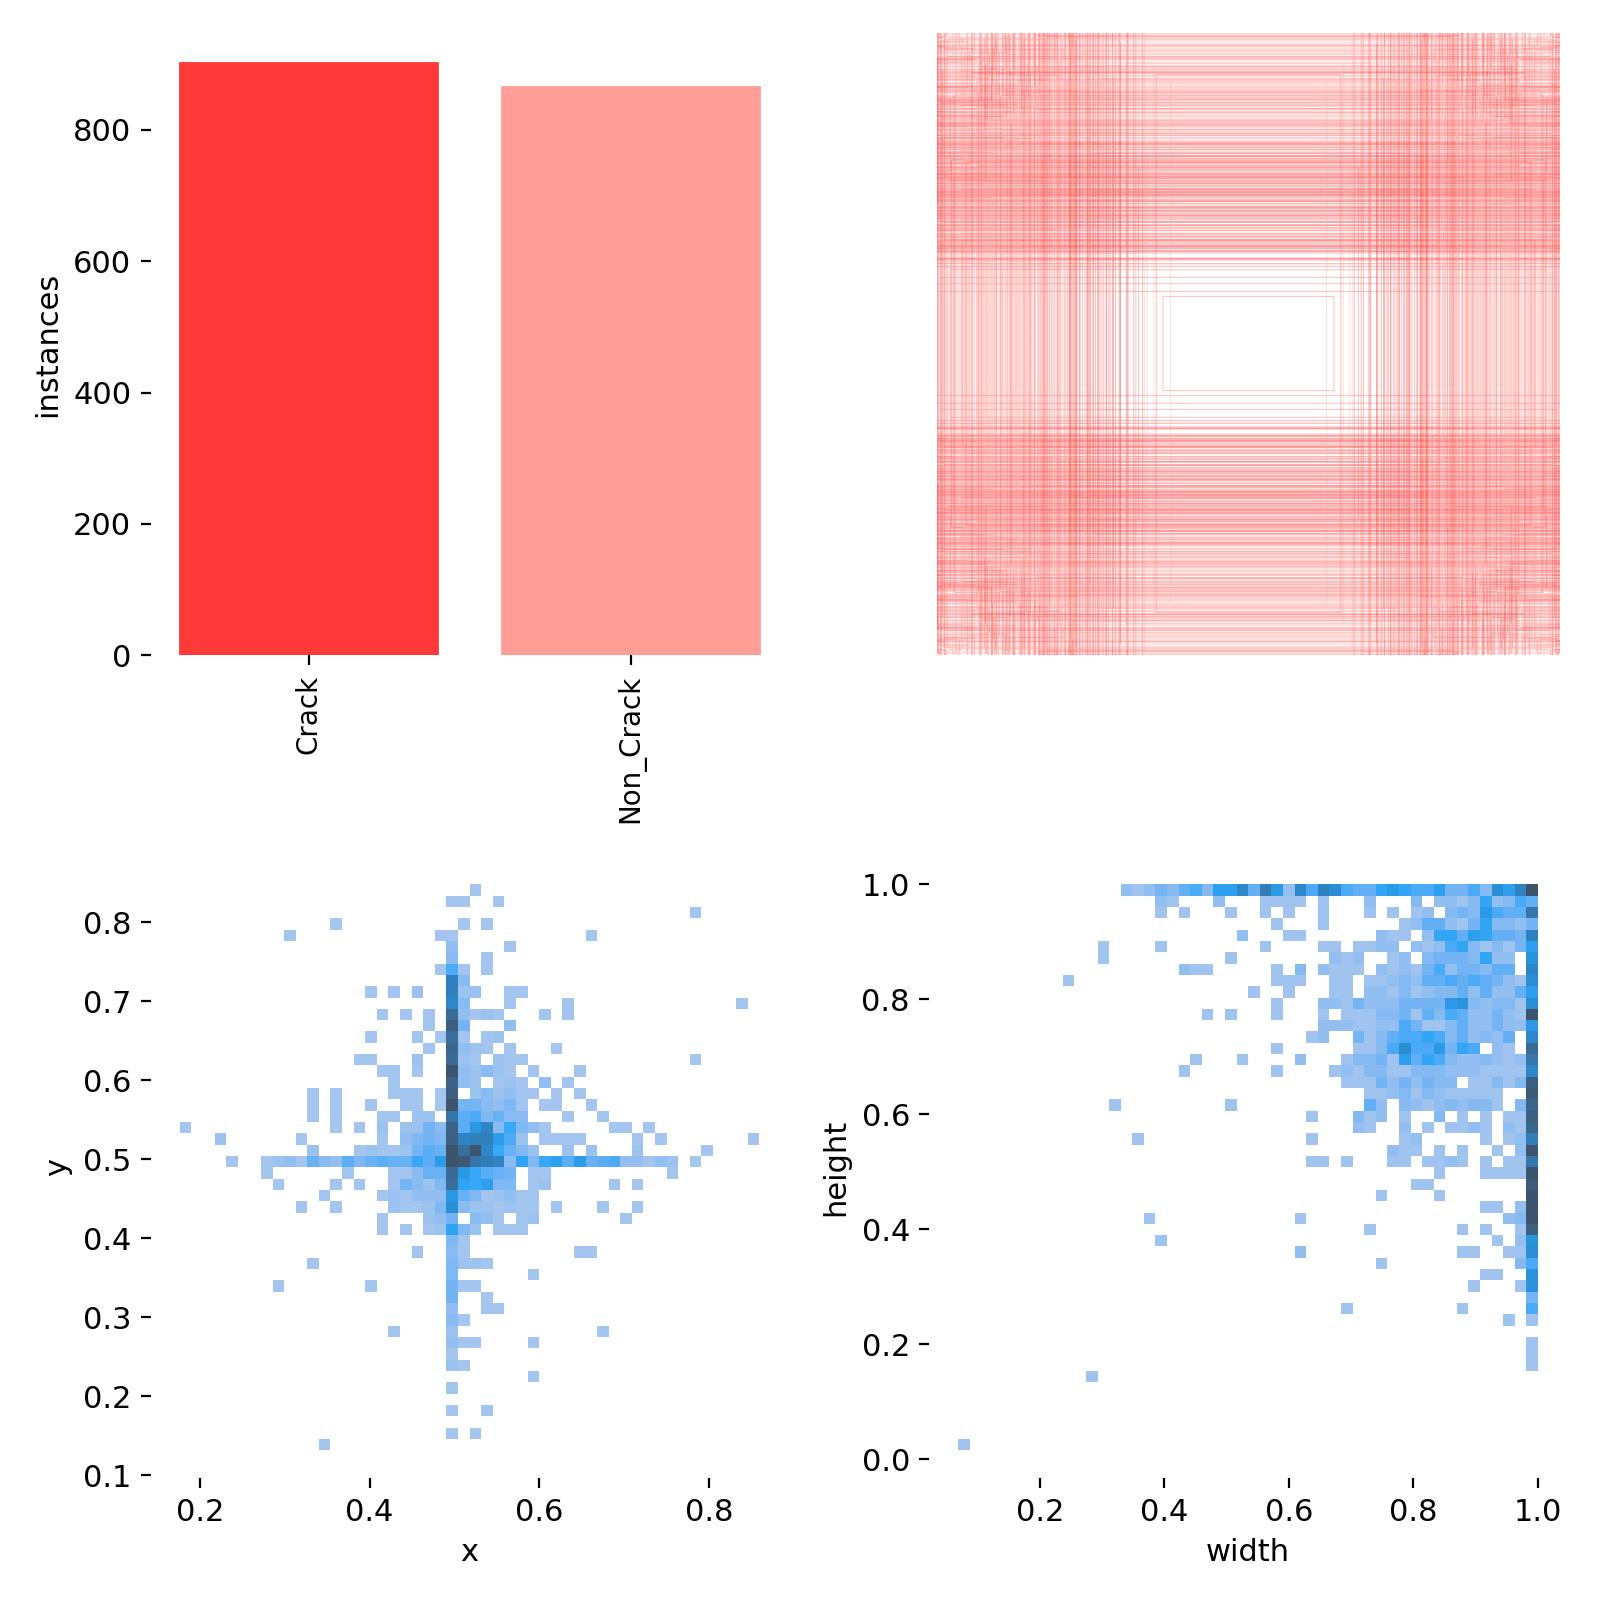

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result3/labels.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

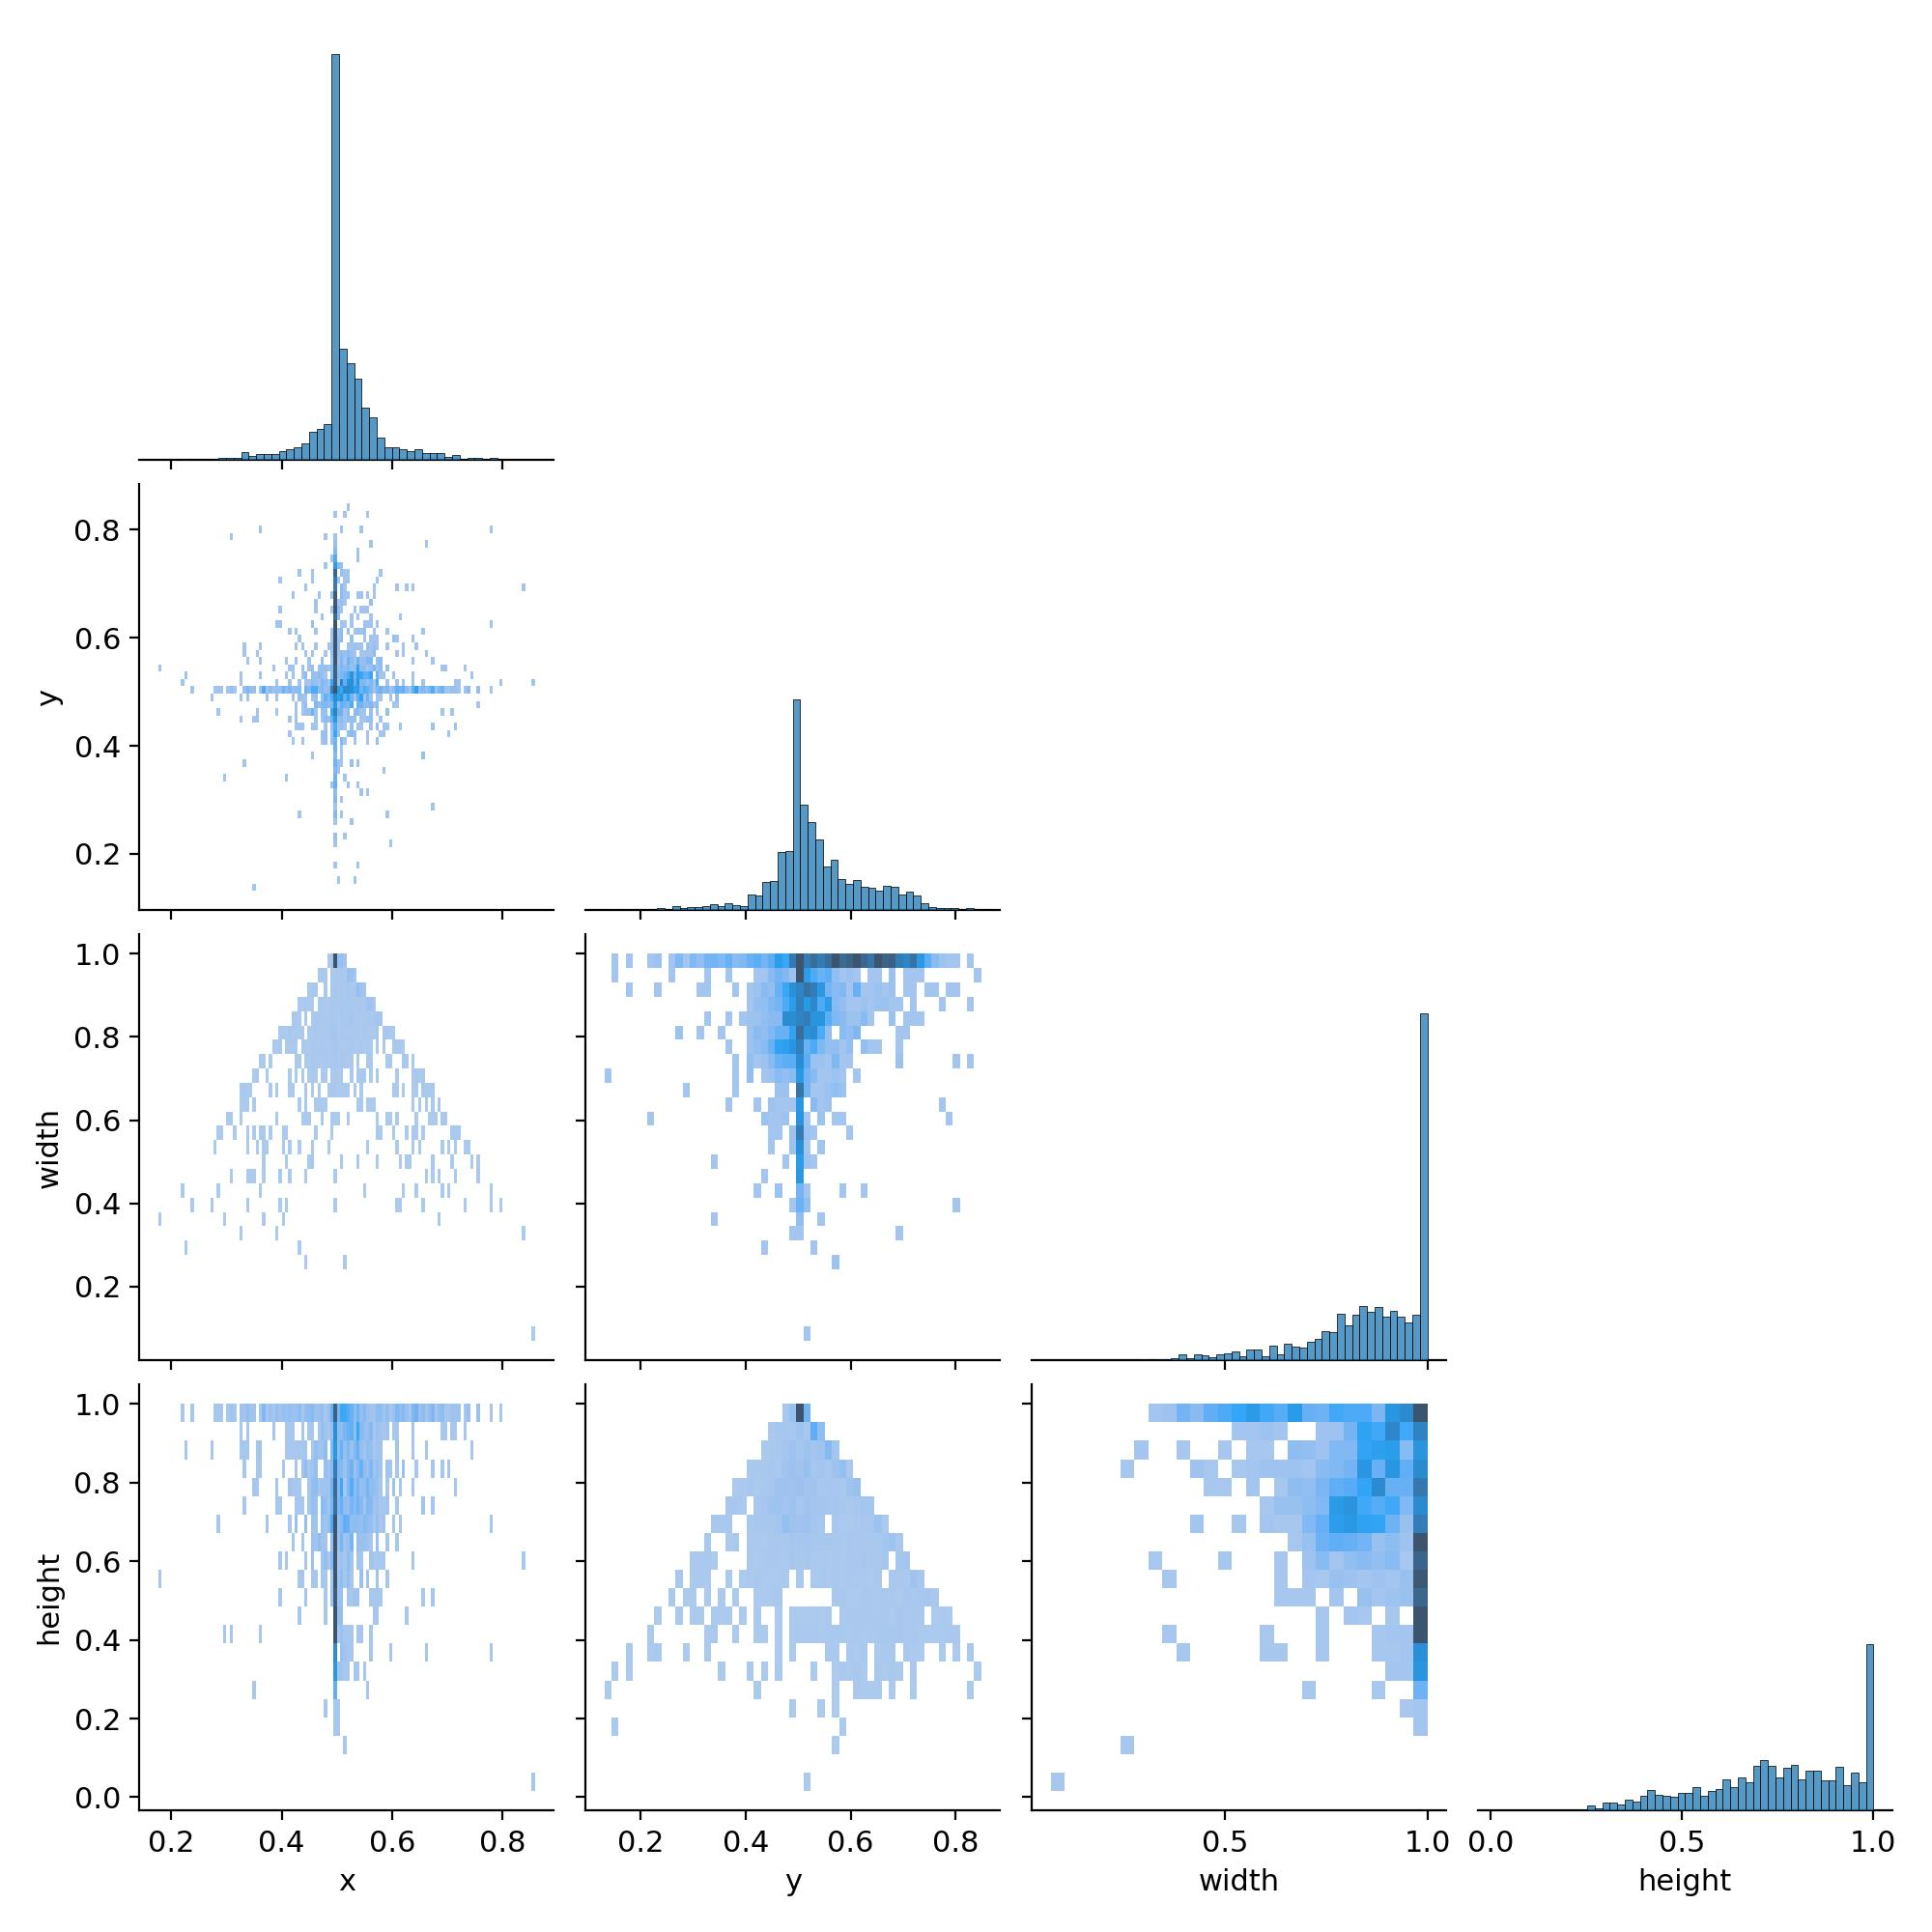

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result3/labels_correlogram.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

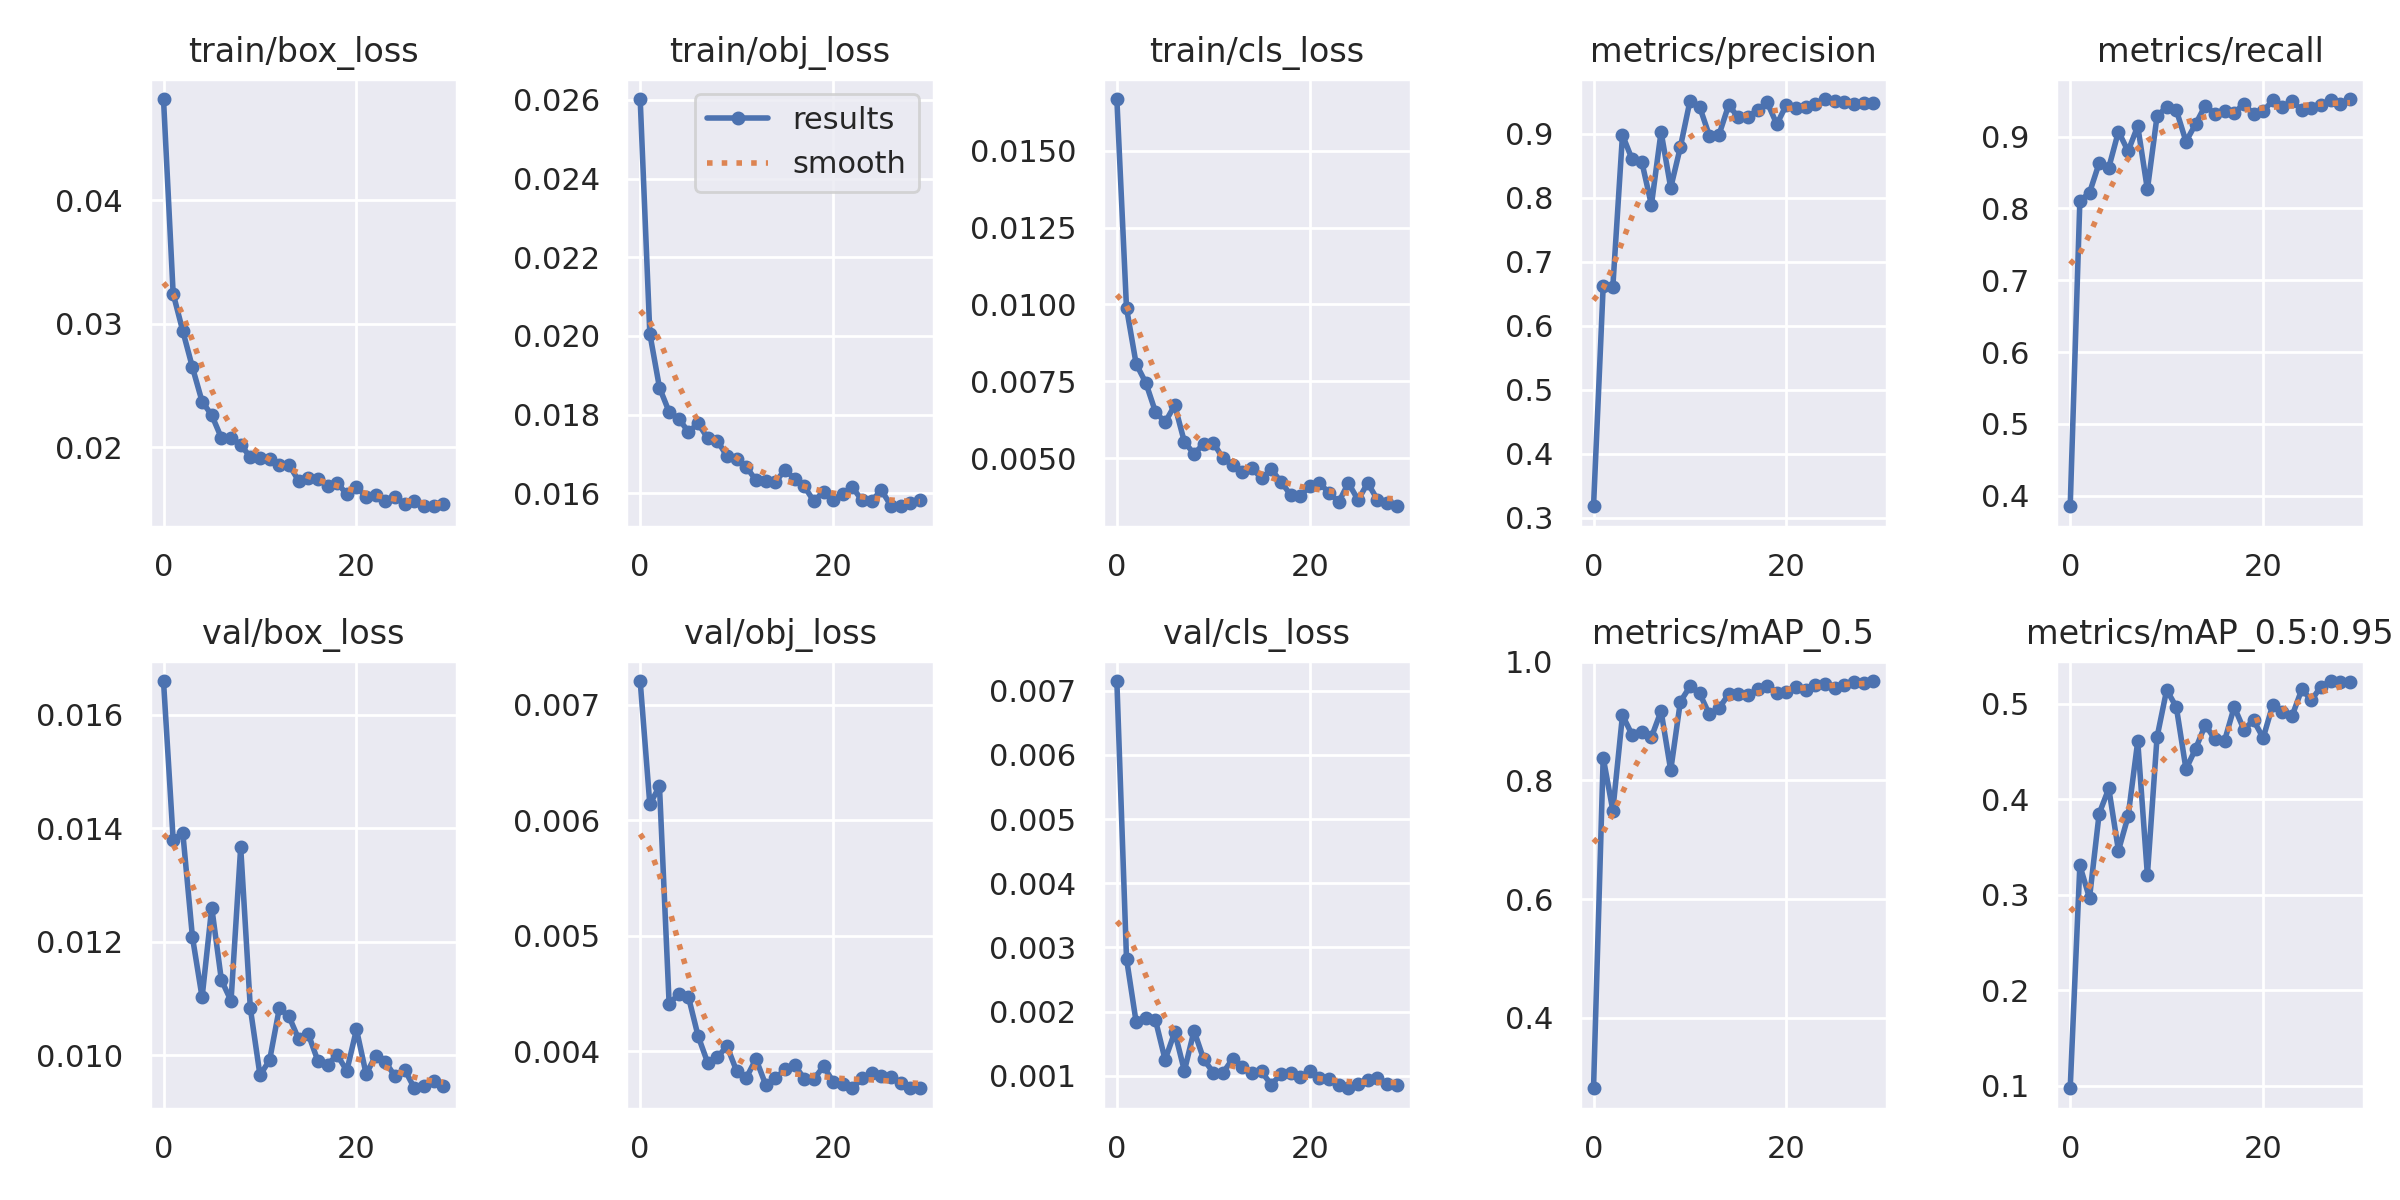

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result3/results.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

#Detection

Detection result:


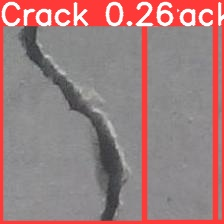

In [ ]:
image_path = '/content/yolov5/runs/detect/exp/00007_jpg.rf.d0f8ba7322d211c8f2dcad225f09215f.jpg'
img = Image.open(image_path)
print('Detection result:')
# Display the image using IPython.display
display(img)

Detection result:


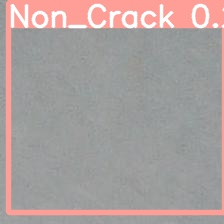

In [ ]:
image_path = '/content/yolov5/runs/detect/exp4/15143_jpg.rf.93786f787975776ddea4354030ae8dd4.jpg'
img = Image.open(image_path)
print('Detection result:')
# Display the image using IPython.display
display(img)